In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
# %matplotlib inline

In [55]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [56]:
len(words)

32033

In [57]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [58]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [59]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [60]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [61]:
# Build look up table
C = torch.randn((27, 2))
C.shape

torch.Size([27, 2])

In [62]:
# Comparing index to one hot (is the same)
print(C[5])
print(F.one_hot(torch.tensor(5), num_classes=27).float() @ C)

tensor([-0.3845, -0.5434])
tensor([-0.3845, -0.5434])


In [63]:
# We use index instead of one hot encoding!
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [64]:
# Build weights and biases
# First dimension is 3 x 2 = 6
# Second dimension is selected by us
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [65]:
# We need to concat our embeddings to can do emb @ W1 + b1
new = emb.view(-1, 6)
print(new)
new.shape

tensor([[-1.3890, -1.0226, -1.3890, -1.0226, -1.3890, -1.0226],
        [-1.3890, -1.0226, -1.3890, -1.0226, -0.3845, -0.5434],
        [-1.3890, -1.0226, -0.3845, -0.5434,  0.1697, -0.4648],
        ...,
        [ 0.1573, -0.4981,  0.1573, -0.4981, -0.6683,  2.0740],
        [ 0.1573, -0.4981, -0.6683,  2.0740,  0.1573, -0.4981],
        [-0.6683,  2.0740,  0.1573, -0.4981, -0.2619, -2.8733]])


torch.Size([228146, 6])

In [66]:
# Caclulate output of tanh layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [67]:
print(h)
h.shape

tensor([[-0.9694,  0.9799,  0.9358,  ..., -0.9297, -0.5664,  0.9693],
        [-0.8652,  0.7027,  0.7700,  ..., -0.7974, -0.6604,  0.9898],
        [-0.5539, -0.3251, -0.1503,  ..., -0.9048, -0.0089,  0.6029],
        ...,
        [ 0.8425,  0.7186,  0.9983,  ..., -0.3212, -0.4348,  0.9996],
        [ 0.3305,  0.9802, -0.9271,  ...,  0.9856, -0.9988, -0.9998],
        [-0.9990,  0.6310, -0.9962,  ...,  0.6560, -0.8044, -0.9998]])


torch.Size([228146, 100])

In [68]:
# Build weights and biases to plug in softmax layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [69]:
# caluclate logit layer
logits = h @ W2 + b2
print(logits)
logits.shape

tensor([[-12.9333,   2.1315,  -7.4195,  ...,  -4.0737,   1.3836,  -3.4054],
        [-13.8561,   7.4015,  -5.6022,  ...,   0.9973,   4.5356, -12.0050],
        [ -1.9072,   4.5641,  -4.4877,  ...,   2.2814,   3.4133,  -2.6806],
        ...,
        [-18.2440,   1.8981,  -6.2210,  ...,  -0.8577,  -3.7128,   0.8510],
        [ -5.0020,  -3.5532,  -7.9353,  ...,   5.7229, -15.8316,  -2.3860],
        [  9.2802,   1.4070, -10.7952,  ..., -16.0676,   3.9651,  -5.6808]])


torch.Size([228146, 27])

In [70]:
# Apply softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [71]:
# Is the sum of logits equals to 1?
prob[0].sum()

tensor(1.0000)

In [72]:
# Build loss
loss = -prob[torch.arange(len(prob)), Y].log().mean()
loss

tensor(16.8035)

In [73]:
# Or we can skip the count and softmax using cross entropy
F.cross_entropy(logits, Y)

tensor(16.8035)

In [74]:
# ------------ now made respectable :) ---------------

In [75]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [76]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [77]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [78]:
# Add grads for every parameter
for p in parameters:
  p.requires_grad = True

In [79]:
# try different learning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [80]:
lri = []
lossi = []
stepi = []

In [81]:
# Run with mini batches adn try different learning rates
for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i].item()
  # lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  # lri.append(lr[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

/var/folders/yn/pbr75brn5_g2b6g7m57pbvk1tpsg0w/T/ipykernel_55979/1889319281.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


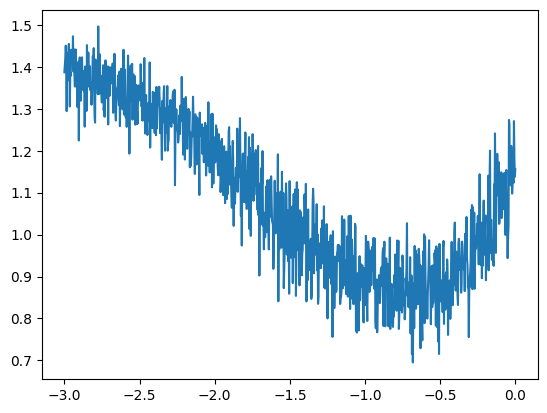

In [82]:
fig, ax = plt.subplots()
ax.plot(lri, lossi)
fig.show()

In [92]:
# Run with mini batches and proper learning rate
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

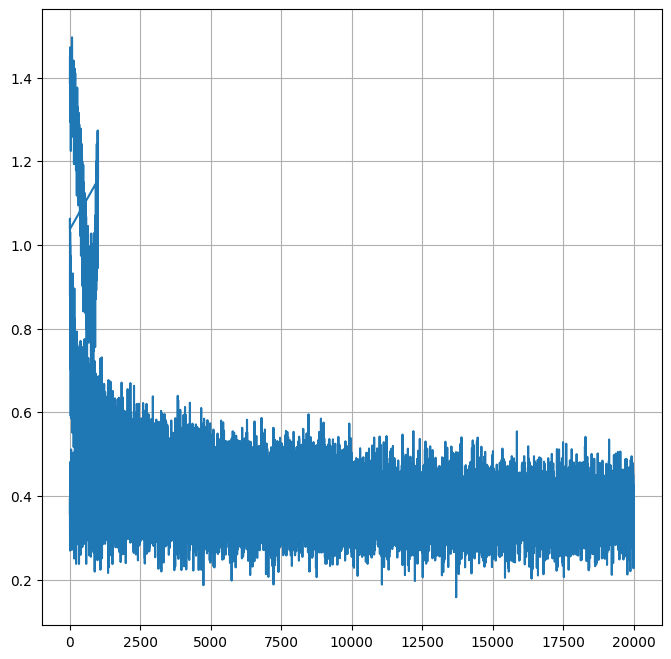

In [93]:
plt.figure(figsize=(8,8))
plt.plot(stepi, lossi)
plt.grid('minor')

In [94]:
# evaluate loss in training
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3154, grad_fn=<NllLossBackward0>)

In [95]:
# evaluate loss in dev
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3522, grad_fn=<NllLossBackward0>)

In [96]:
# evaluate loss in test
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.3604, grad_fn=<NllLossBackward0>)

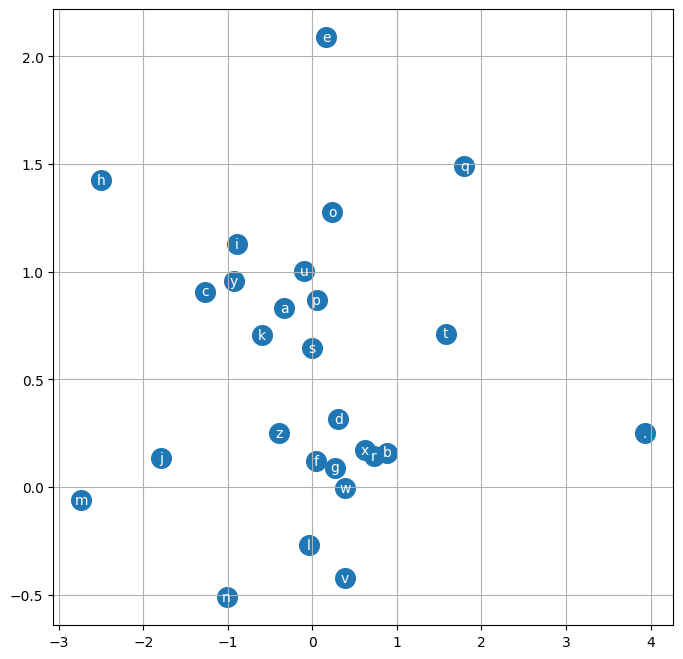

In [97]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [98]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [99]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [100]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mohanamyanneeegen.
hayah.
redhan.
brerlee.
adeeron.
lillelynnelleigh.
kamanaraelyzimanara.
noshubnigahiriel.
kendreeller.
goegson.
bemter.
ryyah.
fyelsy.
majadsen.
daihaanaasyabsun.
zakaleeu.
mayce.
kasheaoen.
por.
brexynovies.
